# Exercise 11.3
Extending the previously assessed models to fit $f(x,y) = \sin(x^2+y^2)$ in the range $x \in [-3/2,3/2]$ and $y \in [-3/2,3/2]$.

Models of different complexity will be assessed showing their training performance using TensorBoard. The most interesting results from the previous exercise will be used to set the other hyperparameters:
|parameter|value|
|---------------------|---------------------|
| activation function | tanh                |
| loss function       | mean absolute error |
| optimizer           | sgd                 |
| learning rate       | 0.001                |

In [1]:
from global_utils import results_dir
from ex11.model_builders import model_builder_11_3
from ex11.utils import eval_params, retrieve_best_params
from ex11.hparams import range_domain
from ex11.data import generate_data
from ex11.plot import plot_target, plot_panel
from tqdm.notebook import tqdm
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random

%load_ext tensorboard

# Prevents tensorflow from printing many useless warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


# Prevents tensorflow from printing many other useless warnings
tf.get_logger().setLevel("ERROR")

sns.set_theme("notebook", "whitegrid", rc={"figure.dpi": 150})


SECTION = "11"
# Seeding the random number generators
random.seed(1)
tf.random.set_seed(1)
rng = np.random.default_rng(1)

# Defining hyperparameters and their domains
# A model of intermediate complexity, wrt. the previous exercise, is used, as the 
model_configs = {"simple": {"n_layers": 2, "n_units": 4}, "intermediate": {"n_layers": 2, "n_units": 16}, "complex": {"n_layers": 2, "n_units": 128}}
other_hparams = {"activation_fn": "tanh", "loss_fn": "mae", "optimizer": "sgd", "lr": 1e-3}

# Whether to use cached results
USE_CACHE = True
RESULTS_DIR = results_dir(SECTION) / "11.3"
CACHE_PATH = RESULTS_DIR / f"results.csv"
os.makedirs(CACHE_PATH.parent, exist_ok=True)

# This value is overkill, but using early stopping we prevent needless computation time
TRAIN_EPOCHS = 100_000
PATIENCE = 5_000
MIN_DELTA = 1e-4

METRIC = "mse"
LOGDIR = RESULTS_DIR / "logs"

def f(x):
    return np.sin(np.square(x).sum(axis=-1))


# Generating the training and test datasets
sigma = 2e-1
N_train = 50 * 50
train_data = generate_data(([-1.5, -1.5], [1.5, 1.5]), f, sigma, N_train, rng)
valid_data = generate_data(([-1.5, -1.5], [1.5, 1.5]), f, sigma, N_train // 10, rng)


In [2]:
# Defining some utilities
def weights_path(model_type):
    """Path to where a model's weights will be stored.

    Args:
        model_type (str): Model's type.

    Returns:
        Path: Path to the model's weights.
    """
    return RESULTS_DIR / "models" / "train" / model_type / "weights.tf"

def load_previous_results():
    # Loading previous results from cache
    dtypes = {hpn: "category" for hpn in other_hparams}
    dtypes["model_type"] = "category"
    for dtype in ["loss", "val_loss", METRIC, f"val_{METRIC}"]:
        dtypes[dtype] = "float"
    for dtype in ["n_layers", "n_units"]:
        dtypes[dtype] = "int"
    search_results_df = pd.read_csv(
        CACHE_PATH, dtype=dtypes, index_col=0)
    models = []
    # Loading previously trained models' weights
    for _, record in search_results_df.iterrows():
        hparams = record.loc[list(other_hparams.keys()) +
                             ["n_units", "n_layers"]]
        model = model_builder_11_3(
            hparams, train_data[0].shape[1:], METRIC)
        model.load_weights(weights_path(record.loc["model_type"]))
        models.append(model)
    return search_results_df, models


In [3]:
# If this cell doesn't show any output try to run it again
%tensorboard --logdir "../results/11/11.3/logs"
# The following considerations are made from the data displayed under the section "SCALARS/epoch_mse"

Reusing TensorBoard on port 6006 (pid 3009), started 0:05:48 ago. (Use '!kill 3009' to kill it.)

In [4]:
run_details = []
models = []
evaluations_df = None

if USE_CACHE and CACHE_PATH.exists():
    evaluations_df, models = load_previous_results()
if evaluations_df is None:
    # Iterating over the model types
    for model_type, m_config in tqdm(model_configs.items()):
        # hparams will store all the run parameters and results
        hparams = other_hparams.copy()
        hparams.update(m_config)
        hparams["model_type"] = model_type
        with tf.device('/device:CPU:0'):
            model, results = eval_params(
                model_builder_11_3,
                hparams,
                METRIC,
                train_data=train_data,
                valid_data=valid_data,
                n_epochs=TRAIN_EPOCHS,
                batch_size=32,
                # Setting EarlyStopping on the validation metric
                early_stopping="valid",
                patience=PATIENCE,
                min_delta=MIN_DELTA,
                restore_best_weights=True,
                # Logging with TensorBoard. The training process can now be checked under the cell above
                # or running `tensorboard --logdir=LOGDIR` in the terminal
                callbacks=[keras.callbacks.TensorBoard(LOGDIR / model_type)]
            )
            # Caching on disk the trained model
            model.save_weights(weights_path(model_type))
            models.append(model)
        run_details.append(hparams.copy())
        run_details[-1].update(results)
    # Storing the run details in a pandas DataFrame
    evaluations_df = pd.DataFrame.from_records(
        run_details,
    ).astype({"loss": "float", "val_loss": "float", METRIC: "float", f"val_{METRIC}": "float"})
    evaluations_df.to_csv(CACHE_PATH)


Metal device set to: Apple M1


Each model's training history can be checked in TensorBoard under the "SCALARS" tab. It is an extremely useful feature to compare hyperparameters and guess wether a model is overfitting/underfitting.

In this case, by checking out the section "epoch_mse", we can see that all three models stopped before overfitting thanks to the early stopping feature. "intermediate" and "complex" were technically still improving in validation, but at such a slow pace ($<10^{-4}$ every 5000 steps) that it didn't seem worth it to go on.

This time we see that the "simple" model is too simple to provide a competitive fit. "intermediate" and "complex" instead are on par, with "intermediate" requiring half the steps to reach the same performance.

Contour plots of the target, the models predictions and the error will be shown to visually evaluate the models performances.

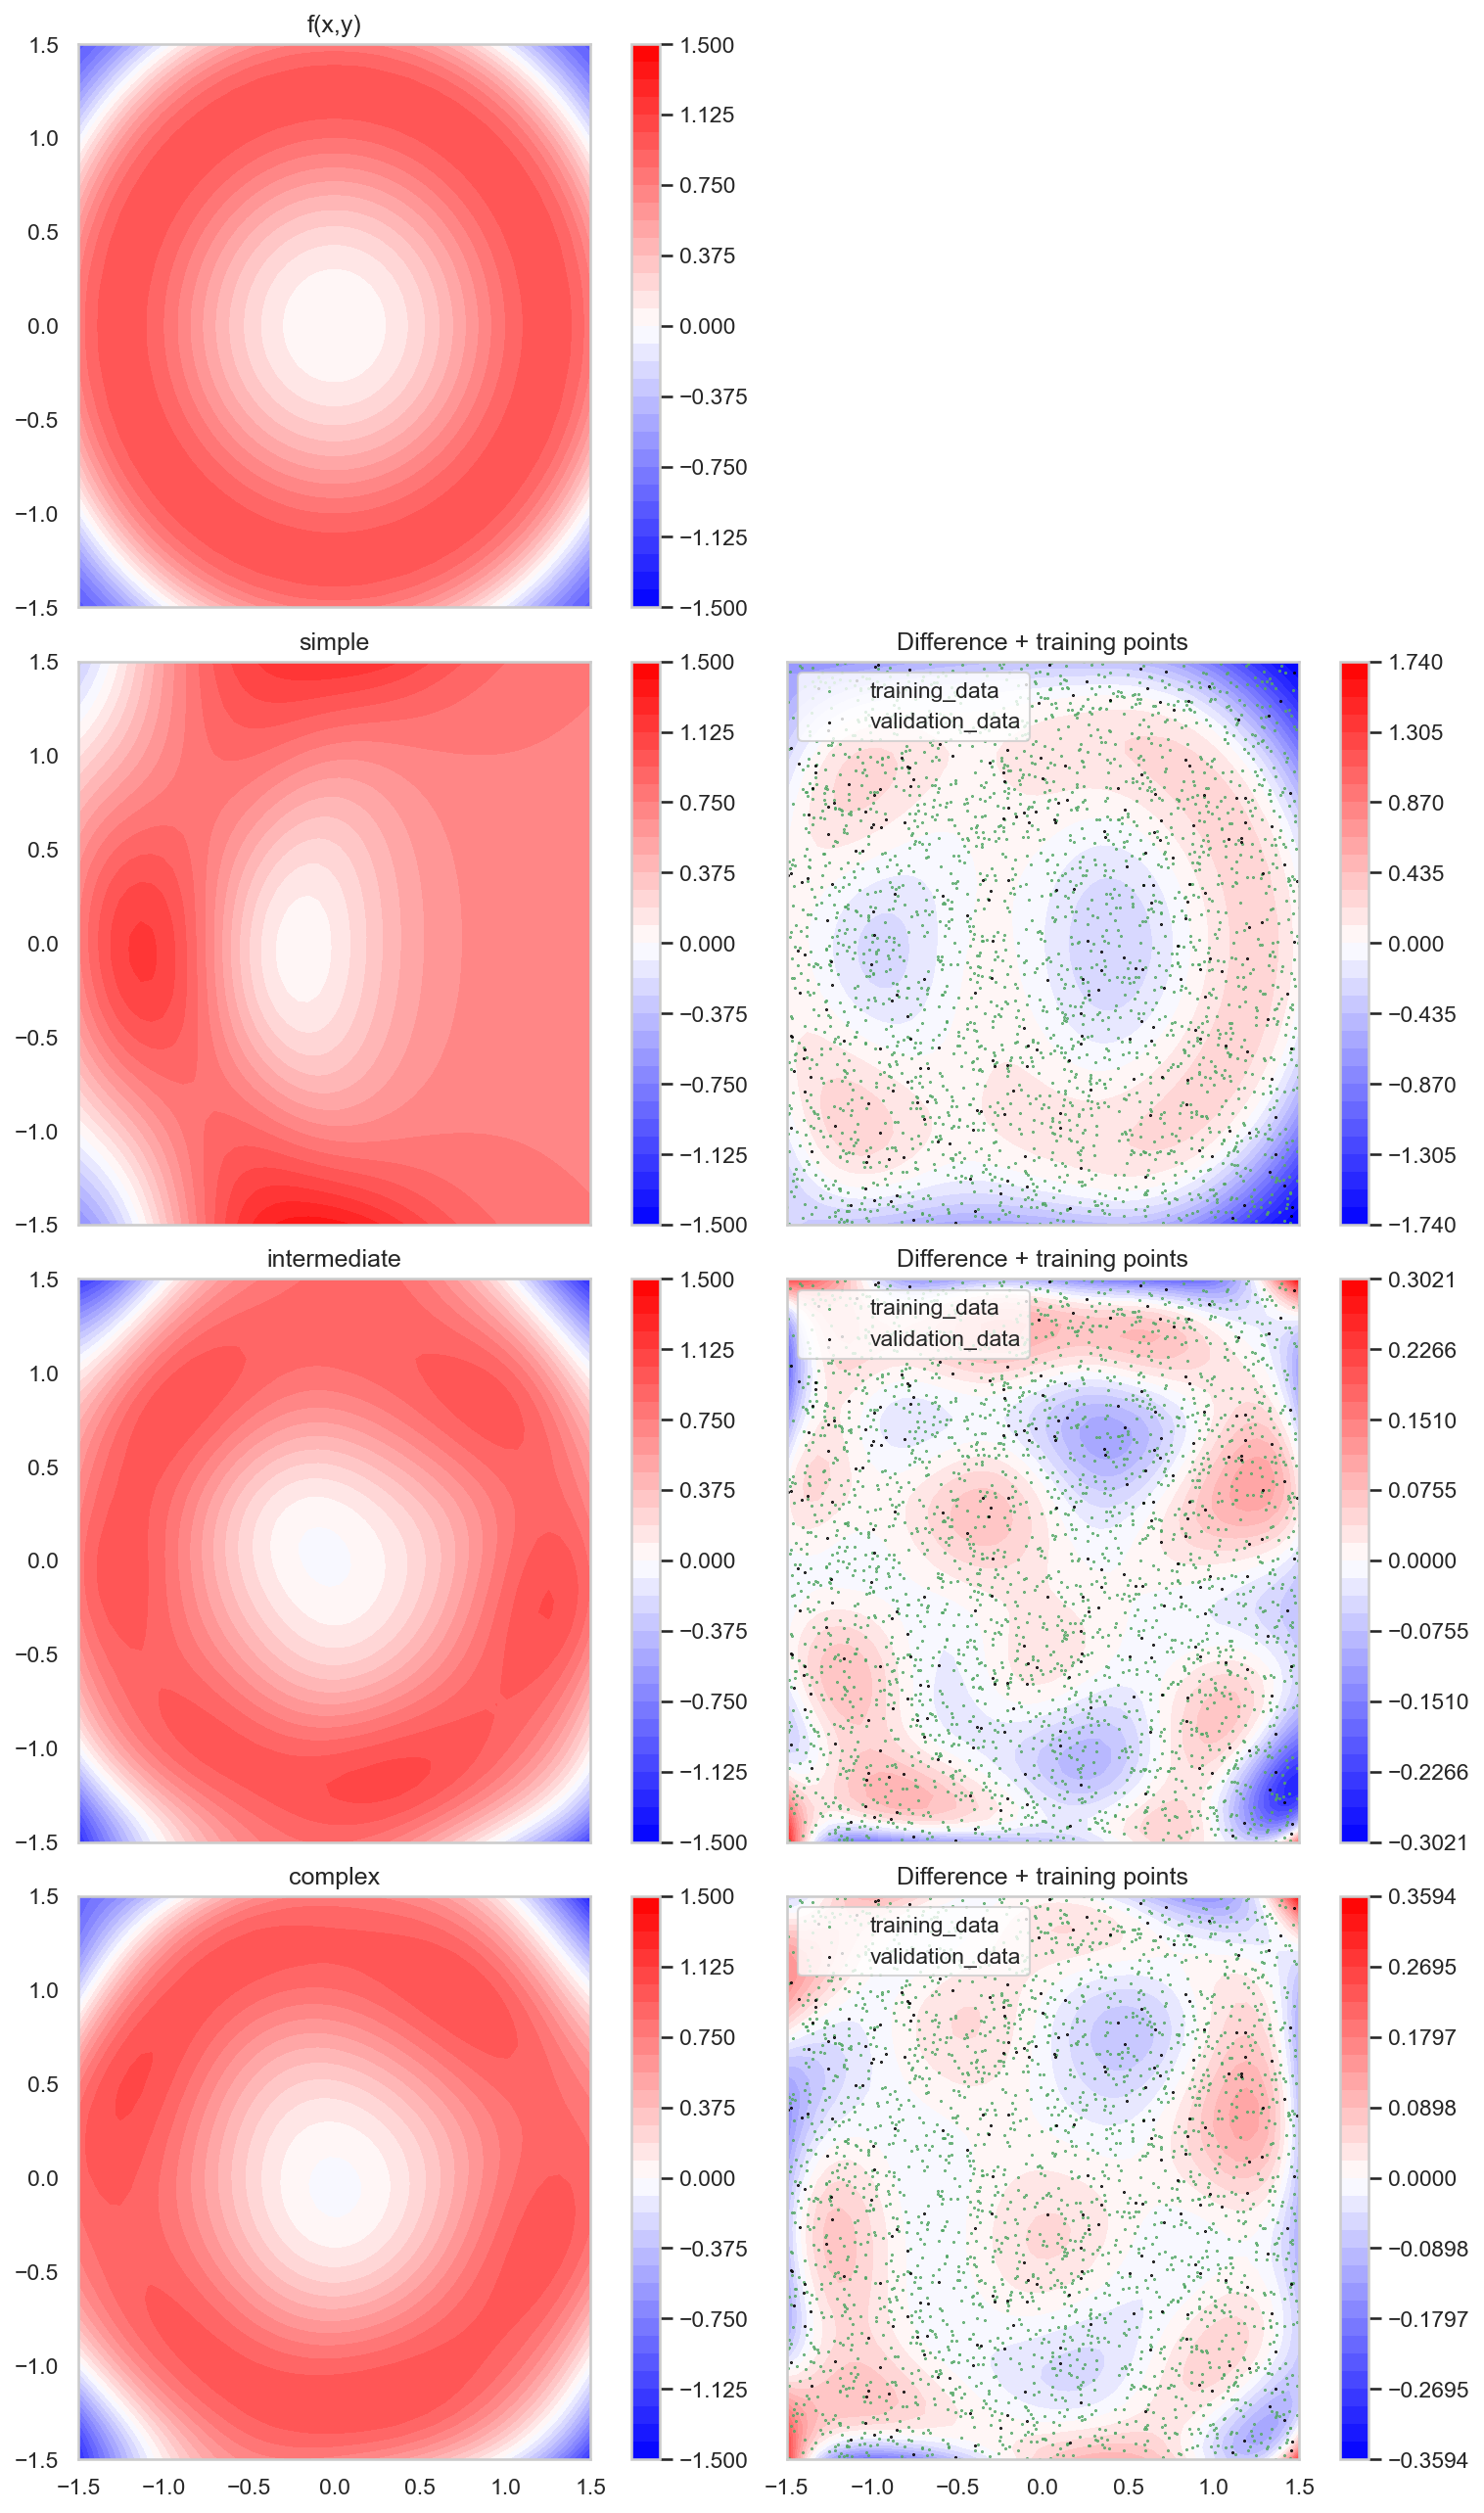

In [5]:
n_levels = 33
fig, axes = plt.subplots(
    4, 2, sharex=True, sharey=True, figsize=(10, 17), constrained_layout=True
)
xs, ys = np.meshgrid(np.linspace(-1.5, 1.5, 50), np.linspace(-1.5, 1.5, 50))
zs = plot_target(xs, ys, f, n_levels, ax=axes[0,0])
for model, axs, model_type in zip(models, axes[1:], model_configs):
    plot_panel(xs, ys, zs, model, model_type, n_levels, train_data, valid_data, axs)

axes[0, 1].set_axis_off()
